In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Run models with shocks

In [3]:
DMO = bfg.DarkMatterOnly(**bpar)
DMB = bfg.DarkMatterBaryon(**bpar)

Baryons3D = bfg.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Baryons3D.setup_interpolator(z_min = 0, z_max = 1, N_samples_z = 2,  R_min = 1e-5, R_max = 1e3, 
                             N_samples_R = 1_000, z_linear_sampling = True, verbose = False);

#Calculate the shock radius impact
Rshock = np.linspace(1, 10, 5)
runner = []
for i in Rshock:
    gas  = bfg.ShockedGas(epsilon_shock = i, width_shock = 0.05, **bpar)
    CLM  = bfg.CollisionlessMatter(gas = gas, **bpar)
    DMB  = bfg.DarkMatterBaryon(gas = gas, collisionlessmatter = CLM, **bpar, xi_mm = None, R_range = [1e-5, 200])

    TMP = bfg.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
    TMP.setup_interpolator(z_min = 0, z_max = 1, N_samples_z = 2, R_min = 1e-5, R_max = 1e3, 
                           N_samples_R = 1_000, z_linear_sampling = True, verbose = True);

    runner.append(TMP)

Building Table: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


# Plot!

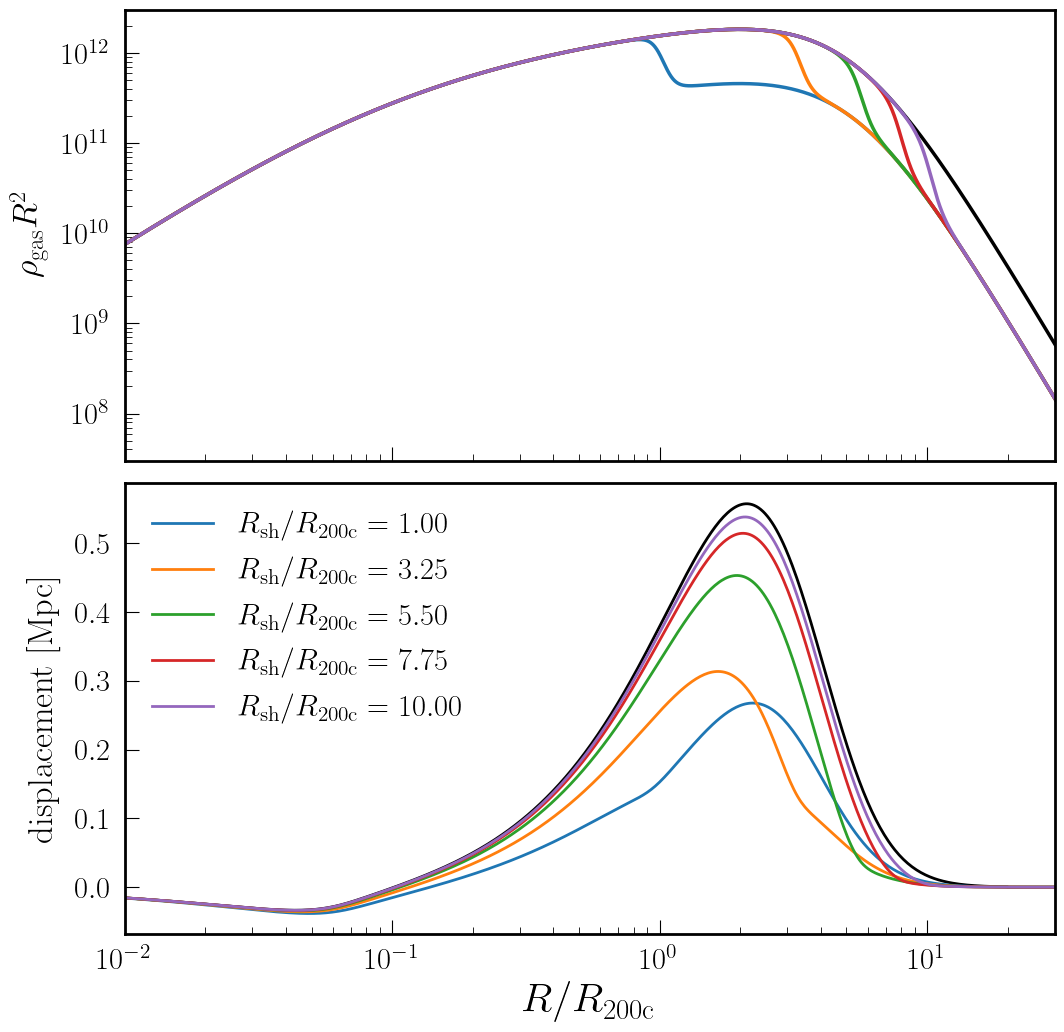

In [4]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12), sharex = True)
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

M = 1e15
a = 1
R = np.geomspace(1e-4, 1000, 10_000)
mdef  = ccl.halos.massdef.MassDef200c
R200c = mdef.get_radius(cosmo, M, a)


#First plot the profiles
ax[0].plot(R/R200c, R**2 * bfg.Gas(**bpar).real(cosmo, R, M, a), color = 'k', lw = 2.5)
for i in range(0, Rshock.size):
    ax[0].plot(R/R200c, 
               R**2 * bfg.ShockedGas(epsilon_shock = Rshock[i], width_shock = 0.05, **bpar).real(cosmo, R, M, a), 
               lw = 2.5, color = 'C%d' % i, rasterized = True)

for i in range(len(runner)):
    ax[1].plot(R/R200c, runner[i].displacement(R*a, M, a), lw = 2,
               label = r'$R_{\rm sh}/R_{\rm 200c} = %0.2f$' % (Rshock[i]), color = 'C%d' % i)

ax[1].plot(R/R200c, Baryons3D.displacement(R*a, M, a), lw = 2, color = 'k', zorder = -100)


ax[1].legend(frameon = False, fontsize = 22, ncol = 1)

[a.tick_params(axis = 'both', pad = 10) for a in ax]
ax[0].set_xlim(1e-2, 30)
ax[1].set_xlabel(r'$R/R_{\rm 200c}$', size = 30)
ax[0].set_ylabel(r'$\rho_{\rm gas} R^2$', size = 25, labelpad = 10)
ax[1].set_ylabel(r'displacement [Mpc]', size = 25, labelpad = 10)

ax[0].set_ylim(3e7, 3e12)
plt.show()